In [1]:
import multiprocessing
import os
from re import A
from typing import ItemsView

from py import log
os.environ['PYTHONDONTWRITEBYTECODE'] = '1'
from xtquant import xttrader
from xtquant.xttrader import XtQuantTrader, XtQuantTraderCallback
from xtquant.xttype import StockAccount
from xtquant import xtconstant
import pandas_market_calendars as mcal
import pandas as pd
import akshare as ak

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
def plot(df, column):
    
    # 设置中文字体
    mpl.rcParams['font.sans-serif'] = ['SimHei']  # 指定中文字体为 SimHei
    mpl.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

    # 假设这是你的DataFrame，其中包含收益

    # 绘制收益曲线
    # 将日期列转换为日期类型
    # df['date'] = pd.to_datetime(df['date'])

    # # 设置日期列为索引
    # df.set_index('date', inplace=True)
    df.index = pd.to_datetime(df.index)
    # 绘制收益曲线
    plt.figure(figsize=(10, 6))  # 设置图表大小
    plt.plot(df.index, df[column], label='Return')
    plt.title('收益曲线')
    plt.xlabel('日期')
    plt.ylabel('收益率')
    plt.legend()  # 显示图例
    plt.grid(True)  # 显示网格线

    # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    # plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))

    plt.show()

d:\anaconda3\envs\python3.8\lib\site-packages\exchange_calendars\exchange_calendar.py:2345: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  align: pd.Timedelta | str = pd.Timedelta(1, "T"),


In [2]:
from xtquant import xtdatacenter as xtdc
xtdc.set_token("26e6009f4de3bfb2ae4b89763f255300e96d6912")

print('xtdc.init')
xtdc.init() # 初始化行情模块，加载合约数据，会需要大约十几秒的时间
print('done')

from xtquant import xtdata 

xtdc.init
done


In [3]:
hd_pct = 0.005

params = [
                    {
                    'filtered': True,
                    'fx_filtered': True,
                    'topn': 1,
                    'top_fx': 4,
                    'top_cx': 4,
                    'only_fx': False,
                    'enbale_industry': False,
                    'empty_priority': False
                    },
                    {
                    'filtered': True,
                    'fx_filtered': True,
                    'topn': 1,
                    'top_fx': 1,
                    'top_cx': 1,
                    'only_fx': True,
                    'enbale_industry': True,
                    'empty_priority': False
                    },
                    {
                    'filtered': True,
                    'fx_filtered': True,
                    'topn': 1,
                    'top_fx': 4,
                    'top_cx': 3,
                    'only_fx': False,
                    'enbale_industry': True,
                    'empty_priority': False
                    }
            ]

In [4]:
def get_real_open_price(stock_code, datekey):
    import datetime

    today = datetime.datetime.strptime(datekey, '%Y-%m-%d').date()

    time_0930 = datetime.time(9, 29, 0)

    dt_0930 = datetime.datetime.combine(today, time_0930)

    timestamp_0930 = dt_0930.timestamp()

    time_09305 = datetime.time(9, 30, 5)

    dt_09305 = datetime.datetime.combine(today, time_09305)

    timestamp_09305 = dt_09305.timestamp()

    tims = int(timestamp_0930*1000)

    tims5 = int(timestamp_09305*1000)
    import numpy as np
    n_data_key = datekey.replace('-', '')
    xtdata.download_history_data(stock_code, 'tick', n_data_key, n_data_key)
    all_tick_data = xtdata.get_market_data(stock_list=[stock_code], period='tick', start_time=n_data_key, end_time=n_data_key)

    # 假设 all_tick_data['000759.SZ'] 是 numpy.void 数组
    if isinstance(all_tick_data[stock_code], np.ndarray) and all_tick_data[stock_code].dtype.type is np.void:
        df = pd.DataFrame(all_tick_data[stock_code].tolist(), columns=all_tick_data[stock_code].dtype.names)
    else:
        raise

    filtered_df = df[(df['time'] >= tims) & (df['time'] <= tims5)]

    # 按 time 列升序排序
    sorted_df = filtered_df.sort_values(by='time')

    # 取 time 最小的行
    min_time_row = sorted_df.head(1)

    last_price = min_time_row['lastPrice']

    # 检查 Series 是否只有一个元素
    if len(last_price) == 1:
        last_price_real = last_price.item()
    else:
        raise Exception(f"{stock_code}-{datekey}")

    return last_price_real

In [5]:
def group_filter_fx(group, filtered = True, fx_filtered = True, topn = 3, top_fx = 2, top_cx = 2, only_fx = False, enbale_industry= False):
    if not filtered:
        valid_rows = group[(group['open_price'] > 0) & (group['next_day_open_price'] > 0) & (group['stock_rank'] <= topn) & (group['next_day_close_price'] > 0)]
        if len(valid_rows) > 0:
            valid_rows['return'] = valid_rows['next_day_open_price'] / valid_rows['open_price'] - 1
            valid_rows['real_return'] = valid_rows['return'] - hd_pct
            valid_rows['close_return'] = valid_rows['next_day_close_price'] / valid_rows['open_price'] - 1
            valid_rows['close_real_return'] = valid_rows['close_return'] - hd_pct
            avg_value = valid_rows['return'].mean()
            close_avg_value = valid_rows['close_return'].mean()
            rank_one_row = group[group['stock_rank'] == 1].copy()
            if len(rank_one_row) > 0:
                # 将平均值赋给 rank 为 1 的行的指定列
                rank_one_row['return'] = avg_value
                rank_one_row['real_return'] = avg_value - hd_pct
                rank_one_row['close_return'] = close_avg_value
                rank_one_row['close_real_return'] = close_avg_value - hd_pct
                return rank_one_row
        else:
            rank_one_row = group[group['stock_rank'] == 1].copy()
            if len(rank_one_row) > 0:
                rank_one_row['return'] = -10
                rank_one_row['real_return'] = -10
                rank_one_row['close_return'] = -10
                rank_one_row['close_real_return'] = -10
                return rank_one_row
    else:
        if fx_filtered:
            min_category_rank = group['max_block_category_rank'].min()
            
            industry_rank_one_row = group[group['max_industry_code_rank'] == 1].copy()
            if not industry_rank_one_row.empty and len(industry_rank_one_row) == 1 and enbale_industry:
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row
            elif not industry_rank_one_row.empty and len(industry_rank_one_row) > 1 and enbale_industry:
                industry_rank_one_row = industry_rank_one_row[industry_rank_one_row['stock_rank'] == industry_rank_one_row['stock_rank'].min()]
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row

            if min_category_rank > top_fx:
                if only_fx:
                    return group[group['max_block_category_rank'] < min_category_rank]
                rank_one_row = group[group['stock_rank'] == 1].copy()
                if len(rank_one_row) > 0:
                    rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                    rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                    return rank_one_row
            else:
                category_filtered = group[(group['max_block_category_rank'] <= top_fx) & ((group['max_block_code_rank'] <= top_cx) | (group['max_industry_code_rank'] <= top_cx))]
                if len(category_filtered) == 0:
                    if only_fx:
                        return group[group['max_block_category_rank'] < min_category_rank]
                    rank_one_row = group[group['stock_rank'] == 1].copy()
                    if not rank_one_row.empty and len(rank_one_row) > 0:
                        rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                        rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                    return rank_one_row

                result = category_filtered[category_filtered['max_block_code_rank'] == category_filtered['max_block_code_rank'].min()]
                if len(result) > 1:
                    result = result[result['stock_rank'] == result['stock_rank'].min()]
                result['return'] = result['next_day_open_price'] / result['open_price'] - 1
                result['real_return'] = result['return'] - hd_pct
                result['close_return'] = result['next_day_close_price'] / result['open_price'] - 1
                result['close_real_return'] = result['close_return'] - hd_pct
                return result
        else:
            rank_one_row = group[group['stock_rank'] == 1].copy()
            if not rank_one_row.empty and len(rank_one_row) > 0:
                rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
            return rank_one_row



def group_filter(group, filtered = True, fx_filtered = True, topn = 3, top_fx = 2, top_cx = 2, only_fx = False, enbale_industry= False):
    if not filtered:
        valid_rows = group[(group['open_price'] > 0) & (group['next_day_open_price'] > 0) & (group['stock_rank'] <= topn) & (group['next_day_close_price'] > 0)]
        if len(valid_rows) > 0:
            valid_rows['return'] = valid_rows['next_day_open_price'] / valid_rows['open_price'] - 1
            valid_rows['real_return'] = valid_rows['return'] - hd_pct
            valid_rows['close_return'] = valid_rows['next_day_close_price'] / valid_rows['open_price'] - 1
            valid_rows['close_real_return'] = valid_rows['close_return'] - hd_pct
            avg_value = valid_rows['return'].mean()
            close_avg_value = valid_rows['close_return'].mean()
            rank_one_row = group[group['stock_rank'] == 1].copy()
            if len(rank_one_row) > 0:
                # 将平均值赋给 rank 为 1 的行的指定列
                rank_one_row['return'] = avg_value
                rank_one_row['real_return'] = avg_value - hd_pct
                rank_one_row['close_return'] = close_avg_value
                rank_one_row['close_real_return'] = close_avg_value - hd_pct
                return rank_one_row
        else:
            rank_one_row = group[group['stock_rank'] == 1].copy()
            if len(rank_one_row) > 0:
                rank_one_row['return'] = -10
                rank_one_row['real_return'] = -10
                rank_one_row['close_return'] = -10
                rank_one_row['close_real_return'] = -10
                return rank_one_row
    else:
        if fx_filtered:
            min_category_rank = group['max_block_category_rank'].min()

            industry_rank_one_row = group[group['max_industry_code_rank'] == 1].copy()
            if not industry_rank_one_row.empty and len(industry_rank_one_row) == 1 and enbale_industry:
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row
            elif not industry_rank_one_row.empty and len(industry_rank_one_row) > 1 and enbale_industry:
                industry_rank_one_row = industry_rank_one_row[industry_rank_one_row['stock_rank'] == industry_rank_one_row['stock_rank'].min()]
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row
            
            if min_category_rank > top_fx:
                if only_fx:
                    return group[group['max_block_category_rank'] < min_category_rank]
                rank_one_row = group[group['stock_rank'] == 1].copy()
                if len(rank_one_row) > 0:
                    rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                    rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                    return rank_one_row
            elif min_category_rank < 0:
                category_filtered = group[(group['max_block_category_rank'] > 0) & (group['max_block_category_rank'] <= top_fx) & (((group['max_block_code_rank'] <= top_cx) & (group['max_block_code_rank'] > 0)) | ((group['max_industry_code_rank'] <= top_cx) & (group['max_industry_code_rank'] > 0)))]
                if not category_filtered.empty and len(category_filtered) > 0:
                    category_filtered = category_filtered[category_filtered['stock_rank'] == category_filtered['stock_rank'].min()]
                    category_filtered['return'] = category_filtered['next_day_open_price'] / category_filtered['open_price'] - 1
                    category_filtered['real_return'] = category_filtered['return'] - hd_pct
                    category_filtered['close_return'] = category_filtered['next_day_close_price'] / category_filtered['open_price'] - 1
                    category_filtered['close_real_return'] = category_filtered['close_return'] - hd_pct
                    return category_filtered
                else:
                    rank_one_row = group[group['max_block_category_rank'] == min_category_rank]
                    if len(rank_one_row) > 0:
                        rank_one_row = rank_one_row[rank_one_row['stock_rank'] == rank_one_row['stock_rank'].min()].copy()
                        if not rank_one_row.empty and len(rank_one_row) > 0:
                            rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                            rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                            rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                            rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                            return rank_one_row
                    if only_fx:
                        return group[group['max_block_category_rank'] < min_category_rank]
                    rank_one_row = group[group['stock_rank'] == 1].copy()
                    if not rank_one_row.empty and len(rank_one_row) > 0:
                        rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                        rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                        return rank_one_row
                    else:
                        raise Exception("No data.")
            else:
                result = group[(group['max_block_category_rank'] > 0) & (group['max_block_category_rank'] <= top_fx) & (((group['max_block_code_rank'] <= top_cx) & (group['max_block_code_rank'] > 0)) | ((group['max_industry_code_rank'] <= top_cx) & (group['max_industry_code_rank'] > 0)))]
                
                if result.empty or len(result) < 1:
                    if only_fx:
                        return group[group['max_block_category_rank'] < min_category_rank]
                    rank_one_row = group[group['stock_rank'] == 1].copy()
                    if not rank_one_row.empty and len(rank_one_row) > 0:
                        rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                        rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                        return rank_one_row
                if len(result) > 1:
                    result = result[result['stock_rank'] == result['stock_rank'].min()]
                result['return'] = result['next_day_open_price'] / result['open_price'] - 1
                result['real_return'] = result['return'] - hd_pct
                result['close_return'] = result['next_day_close_price'] / result['open_price'] - 1
                result['close_real_return'] = result['close_return'] - hd_pct
                return result
        else:
            rank_one_row = group[group['stock_rank'] == 1].copy()
            if not rank_one_row.empty and len(rank_one_row) > 0:
                rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
            return rank_one_row


In [6]:
param0 = params[0]
empty_priority = param0['empty_priority']
del param0['empty_priority']
if empty_priority:
    filter_func = group_filter_fx
else:
    filter_func = group_filter

filter_func

<function __main__.group_filter(group, filtered=True, fx_filtered=True, topn=3, top_fx=2, top_cx=2, only_fx=False, enbale_industry=False)>

In [ ]:
import sqlite3
# months = ['202502']
months = ['202409', '202410', '202411', '202412', '202501', '202502','202503' ]
# months = ['202411', '202412', '202501', '202502']
combined_df = pd.DataFrame()
for month in months:
    conn = sqlite3.connect('D:\workspace\TradeX\ezMoney\sqlite_db\strategy_data.db')
    db_name = 'strategy_data_aftermarket_%s' % month
    query = "select * from %s where (sub_strategy_name = '中位低吸') and stock_rank <= 3" % db_name
    df = pd.read_sql_query(query, conn)
    combined_df = pd.concat([combined_df, df], axis=0)
combined_df = combined_df.reset_index(drop=True)
combined_df

,id,date_key,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,...,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,env_json_info,block_category_info,created_at
0,936,2024-09-03,低吸,中位低吸,002426.XSHE,胜利精密,1,"000038.BKDL,000026.BKDL,000014.BKDL,000035.BKD...","885785.DDBK,885840.DDBK,885467.DDBK,886000.DDB...","980365.ZHBK,980357.ZHBK",...,中位低吸,-66.21,-0.97,56,-54.10,-8.41,41,"{""9A0001"": {""realShortLineScore"": 20.72, ""real...","{""000028.BKDL"": {""categoryCode"": ""000028.BKDL""...",2025-02-15 17:42:38
1,961,2024-09-04,低吸,中位低吸,002806.XSHE,华锋股份,1,"000012.BKDL,000035.BKDL,000027.BKDL","885775.DDBK,885999.DDBK,885662.DDBK,885921.DDB...",980372.ZHBK,...,中位低吸,-35.20,31.01,43,-49.43,-1.06,42,"{""9A0001"": {""realShortLineScore"": 26.55, ""real...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-02-15 17:43:39
2,962,2024-09-04,低吸,中位低吸,603726.XSHG,朗迪集团,2,,,,...,中位低吸,-35.20,31.01,43,-49.43,-1.06,42,"{""9A0001"": {""realShortLineScore"": 26.55, ""real...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-02-15 17:43:39
3,963,2024-09-04,低吸,中位低吸,001319.XSHE,铭科精技,3,"000026.BKDL,000018.BKDL,000027.BKDL","885467.DDBK,885834.DDBK,885999.DDBK,886000.DDB...",980372.ZHBK,...,中位低吸,-35.20,31.01,43,-49.43,-1.06,42,"{""9A0001"": {""realShortLineScore"": 26.55, ""real...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-02-15 17:43:39
4,1016,2024-09-05,低吸,中位低吸,603189.XSHG,网达软件,1,"000012.BKDL,000008.BKDL,000026.BKDL,000015.BKD...","885980.DDBK,885759.DDBK,886062.DDBK,885472.DDB...","980753.ZHBK,980366.ZHBK",...,中位低吸,-68.59,-33.39,63,-66.71,-15.87,44,"{""9A0001"": {""realShortLineScore"": -12.1, ""real...","{""000003.BKDL"": {""categoryCode"": ""000003.BKDL""...",2025-02-15 17:44:43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,3133,2025-02-27,低吸,中位低吸,002097.XSHE,山河智能,2,"000038.BKDL,000026.BKDL,000018.BKDL,000035.BKD...","885743.DDBK,885840.DDBK,886021.DDBK,886066.DDB...",980365.ZHBK,...,中位低吸,126.09,38.14,11,42.13,0.33,16,"{""9A0001"": {""realShortLineScore"": 43.12, ""real...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-02-28 17:32:56
288,3134,2025-02-27,低吸,中位低吸,002824.XSHE,和胜股份,3,,,,...,中位低吸,126.09,38.14,11,42.13,0.33,16,"{""9A0001"": {""realShortLineScore"": 43.12, ""real...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-02-28 17:32:56
289,3700,2025-02-28,低吸,中位低吸,000892.XSHE,欢瑞世纪,1,"000012.BKDL,000010.BKDL","885420.DDBK,885788.DDBK,886060.DDBK,885890.DDB...","980355.ZHBK,980348.ZHBK",...,中位低吸,117.85,-17.19,12,40.81,-6.17,16,"{""9A0001"": {""realShortLineScore"": -20.48, ""rea...","{""000033.BKDL"": {""categoryCode"": ""000033.BKDL""...",2025-03-03 08:00:48
290,3701,2025-02-28,低吸,中位低吸,002522.XSHE,浙江众成,2,"000036.BKDL,000006.BKDL,000004.BKDL,000022.BKD...","885924.DDBK,886021.DDBK,885806.DDBK,885929.DDB...","980364.ZHBK,980373.ZHBK",...,中位低吸,117.85,-17.19,12,40.81,-6.17,16,"{""9A0001"": {""realShortLineScore"": -20.48, ""rea...","{""000033.BKDL"": {""categoryCode"": ""000033.BKDL""...",2025-03-03 08:00:48


In [8]:
combined_df = combined_df.drop(['env_json_info', 'block_category_info'], axis=1)
combined_df = combined_df[combined_df['strategy_name'] == '低吸']
combined_df = combined_df.groupby(['date_key', 'strategy_name', 'sub_strategy_name']).apply(filter_func, **param0).reset_index(drop=True)

# 将索引设置为 date_key 列
combined_df = combined_df.set_index('date_key')

# 对索引进行排序
combined_df = combined_df.sort_index()


combined_df

C:\Users\Administrator\AppData\Local\Temp\ipykernel_10904\1079973233.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  combined_df = combined_df.groupby(['date_key', 'strategy_name', 'sub_strategy_name']).apply(filter_func, **param0).reset_index(drop=True)


,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,...,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,created_at,return,real_return,close_return,close_real_return
date_key,,,,,,,,,,,,,,,,,,,,,
2024-09-03,936,低吸,中位低吸,002426.XSHE,胜利精密,1,"000038.BKDL,000026.BKDL,000014.BKDL,000035.BKD...","885785.DDBK,885840.DDBK,885467.DDBK,886000.DDB...","980365.ZHBK,980357.ZHBK",4,...,-0.97,56,-54.10,-8.41,41,2025-02-15 17:42:38,0.000000,-0.005000,-0.011111,-0.016111
2024-09-04,963,低吸,中位低吸,001319.XSHE,铭科精技,3,"000026.BKDL,000018.BKDL,000027.BKDL","885467.DDBK,885834.DDBK,885999.DDBK,886000.DDB...",980372.ZHBK,1,...,31.01,43,-49.43,-1.06,42,2025-02-15 17:43:39,0.019608,0.014608,0.030812,0.025812
2024-09-05,1016,低吸,中位低吸,603189.XSHG,网达软件,1,"000012.BKDL,000008.BKDL,000026.BKDL,000015.BKD...","885980.DDBK,885759.DDBK,886062.DDBK,885472.DDB...","980753.ZHBK,980366.ZHBK",1,...,-33.39,63,-66.71,-15.87,44,2025-02-15 17:44:43,0.021012,0.016012,-0.042802,-0.047802
2024-09-06,1057,低吸,中位低吸,603189.XSHG,网达软件,2,"000012.BKDL,000008.BKDL,000026.BKDL,000015.BKD...","885980.DDBK,885759.DDBK,886062.DDBK,885472.DDB...","980753.ZHBK,980366.ZHBK",3,...,40.75,40,-44.34,12.61,40,2025-02-15 17:45:49,-0.070884,-0.075884,-0.046494,-0.051494
2024-09-19,1364,低吸,中位低吸,002717.XSHE,岭南股份,1,"000012.BKDL,000008.BKDL,000018.BKDL,000023.BKD...","885750.DDBK,885572.DDBK,885694.DDBK,885806.DDB...","980338.ZHBK,980346.ZHBK,980756.ZHBK",2,...,-3.59,50,-77.94,2.54,64,2025-02-15 17:53:14,0.171642,0.166642,0.246269,0.241269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-24,2949,低吸,中位低吸,600678.XSHG,四川金顶,1,"000035.BKDL,000011.BKDL,000027.BKDL,000007.BKD...","885782.DDBK,886021.DDBK,885710.DDBK,885517.DDB...",980368.ZHBK,1,...,-6.57,20,7.45,-5.74,30,2025-02-28 17:29:42,-0.040698,-0.045698,-0.047674,-0.052674
2025-02-25,3006,低吸,中位低吸,001306.XSHE,夏厦精密,2,"000008.BKDL,000038.BKDL,000027.BKDL,000004.BKD...","885930.DDBK,885598.DDBK,885517.DDBK,885929.DDB...",980365.ZHBK,1,...,-18.91,17,0.81,-12.87,30,2025-02-28 17:30:50,0.024283,0.019283,0.086725,0.081725
2025-02-26,3081,低吸,中位低吸,002522.XSHE,浙江众成,1,"000036.BKDL,000006.BKDL,000004.BKDL,000022.BKD...","885924.DDBK,886021.DDBK,885806.DDBK,885929.DDB...","980364.ZHBK,980373.ZHBK",2,...,-8.84,11,27.82,8.57,20,2025-02-28 17:31:57,0.056761,0.051761,0.013356,0.008356


In [9]:
from xtquant import xtdata
import time
import pandas as pd

all_stocks = {}
all_stocks_info = xtdata.get_stock_list_in_sector('沪深A股')
for stock in all_stocks_info:
    if stock.startswith('60') or stock.startswith('00'):
        cde = stock.split('.')[0]
        all_stocks[cde] = stock
for i in range(1, 11):
    combined_df[f'close_{i}'] = -1
    combined_df[f'low_{i}'] = -1
combined_df['real_open'] = -1
for date_key, row in combined_df.iterrows():
    stock_code = row['stock_code']
    stock_code = all_stocks[stock_code.split('.')[0]]
    n_data_key = date_key
    if '-' in n_data_key:
        n_data_key = n_data_key.replace('-', '')
    xtdata.download_history_data(stock_code, '1m', n_data_key, n_data_key)
    all_data = xtdata.get_market_data(stock_list=[stock_code], period='1m', start_time=n_data_key, end_time=n_data_key)

    df = pd.DataFrame()
    for key in all_data.keys():
        ndf = all_data[key].T
        ndf = ndf.sort_index()
        ndf.columns = [key]
        df = pd.concat([df, ndf], axis=1)
    
    i = 1
    for idx, rrow in df[1:11].iterrows():
        combined_df.loc[date_key, f'close_{i}'] = rrow['close']
        combined_df.loc[date_key, f'low_{i}'] = rrow['low']
        i += 1
    real_open_price = get_real_open_price(stock_code, date_key)
    combined_df.loc[date_key, 'real_open'] = real_open_price

***** xtdata连接成功 *****
服务信息: {'tag': 'xtquant', 'version': '1.0'}
服务地址: 127.0.0.1:58609
数据路径: d:\workspace\TradeX\notebook\data\datadir
设置xtdata.enable_hello = False可隐藏此消息



C:\Users\Administrator\AppData\Local\Temp\ipykernel_10904\498375655.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.77' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  combined_df.loc[date_key, f'close_{i}'] = rrow['close']
C:\Users\Administrator\AppData\Local\Temp\ipykernel_10904\498375655.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.72' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  combined_df.loc[date_key, f'low_{i}'] = rrow['low']
C:\Users\Administrator\AppData\Local\Temp\ipykernel_10904\498375655.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype firs

In [10]:
combined_df[['open_price', 'next_day_close_price', 'low_1', 'low_2', 'low_3', 'low_4', 'low_5', 'low_6', 'low_7', 'low_8', 'low_9', 'low_10']]

,open_price,next_day_close_price,low_1,low_2,low_3,low_4,low_5,low_6,low_7,low_8,low_9,low_10
date_key,,,,,,,,,,,,
2024-09-03,1.80,1.78,1.72,1.74,1.75,1.76,1.77,1.76,1.76,1.79,1.79,1.81
2024-09-04,17.85,18.40,17.78,18.16,18.10,17.91,17.89,17.88,17.94,17.96,17.71,17.65
2024-09-05,12.85,12.30,12.86,12.98,12.91,12.97,13.02,13.06,12.96,12.95,12.96,12.91
2024-09-06,13.12,12.51,12.93,12.85,12.83,12.84,12.74,12.71,12.78,12.76,12.71,12.69
2024-09-19,1.34,1.67,1.37,1.38,1.41,1.39,1.38,1.40,1.39,1.41,1.45,1.46
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-24,8.60,8.19,8.69,8.68,8.91,8.91,9.05,9.07,9.21,9.42,9.63,9.71
2025-02-25,86.48,93.98,86.10,87.34,87.79,90.01,90.19,91.50,91.59,90.09,90.48,91.00
2025-02-26,5.99,6.07,6.02,6.10,6.19,6.20,6.28,6.34,6.35,6.32,6.25,6.25


In [11]:
# combined_df['avg_close'] = 0
# for i in range(1, 11):
#     combined_df['avg_close'] += combined_df['close_%s' % i]
# combined_df['avg_close'] = combined_df['avg_close'] / 10
dwndx = combined_df[combined_df['open_price'] > 0]
ddwndx = dwndx

In [12]:
def caculate_returns(returns_df, row, _print = False):
    r = {}
    cumulative_returns = (1 + returns_df[row]).cumprod()

    # 计算最大回撤
    cumulative_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()

    # 计算夏普比率
    risk_free_rate = 0.0  # 假设无风险利率为0
    sharpe_ratio = (returns_df[row].mean() - risk_free_rate) / returns_df[row].std()

    # 计算总收益率
    total_return = cumulative_returns.iloc[-1] - 1

    # 计算波动率
    volatility = returns_df[row].std()

    # 计算总盈亏
    total_profit_loss = cumulative_returns.iloc[-1] - cumulative_returns.iloc[0]

    # 计算成功次数、胜率、平均盈利、平均亏损、最大盈利、最大亏损以及盈亏比
    profitable_trades = returns_df[row][returns_df[row] > 0].count()
    losing_trades = returns_df[row][returns_df[row] < 0].count()
    win_rate = profitable_trades / (profitable_trades + losing_trades) if (profitable_trades + losing_trades) > 0 else 0
    average_profit = returns_df[row][returns_df[row] > 0].mean() if profitable_trades > 0 else 0
    average_loss = returns_df[row][returns_df[row] < 0].mean() if losing_trades > 0 else 0
    max_profit = returns_df[row].max()
    max_loss = returns_df[row].min()
    total_trades = profitable_trades + losing_trades
    total_times = returns_df[row].count()
    trade_pct = total_times / total_trades
    profit_loss_ratio = average_profit / abs(average_loss) if average_loss != 0 else 0
    kelly_fraction = win_rate - ((1 - win_rate) / profit_loss_ratio) if profit_loss_ratio != 0 else 0
    return_per_day = total_return / total_times
    year_return = return_per_day * 240

    r['最大回撤'] =  max_drawdown
    r['夏普比率'] =  sharpe_ratio
    r['总收益率'] =  total_return
    r['波动率'] = volatility
    r['年化收益率'] = year_return
    r['总盈亏'] = total_profit_loss
    r['成功次数'] = profitable_trades
    r['失败次数'] = losing_trades
    r['总天数'] = total_times
    r['总交易次数'] = total_trades
    r['交易频率'] = trade_pct
    r['胜率'] = win_rate
    r['平均盈利'] = average_profit
    r['平均亏损'] = average_loss
    r['最大盈利'] = max_profit
    r['最大亏损'] = max_loss
    r['盈亏比'] = profit_loss_ratio
    r['凯利公式最佳仓位'] = kelly_fraction
    if _print:
        print(f"最大回撤: {max_drawdown:.2%}")
        print(f"夏普比率: {sharpe_ratio:.2f}")
        print(f"总收益率: {total_return:.2%}")
        print(f"年化收益率: {year_return:.2%}")
        print(f"波动率: {volatility:.2%}")
        print(f"总盈亏: {total_profit_loss:.2%}")
        print(f"成功次数: {profitable_trades}")
        print(f"失败次数: {losing_trades}")
        print(f"总天数: {total_times}")
        print(f"总交易次数: {total_trades}")
        print(f"交易频率: {trade_pct:.2%}")
        print(f"胜率: {win_rate:.2%}")
        print(f"平均盈利: {average_profit:.2%}")
        print(f"平均亏损: {average_loss:.2%}")
        print(f"最大盈利: {max_profit:.2%}")
        print(f"最大亏损: {max_loss:.2%}")
        print(f"盈亏比: {profit_loss_ratio:.2f}")
        print(f"凯利公式最佳仓位: {kelly_fraction:.2%}")

    return r

In [ ]:

ddwndx['r_return'] = ddwndx['next_day_close_price']/ddwndx['real_open'] - 1
ddwndx['r_return'] = ddwndx['r_return']-0.001
ddwndx['cumulative_returns'] = (1 + ddwndx['r_return']).cumprod()
print("return:")
caculate_returns(ddwndx, 'r_return', _print=True)
print('-----------------------------------------------------')

return:
最大回撤: -66.86%
夏普比率: 0.17
总收益率: 268.46%
年化收益率: 613.62%
波动率: 9.88%
总盈亏: 271.29%
成功次数: 53
失败次数: 52
总天数: 105
总交易次数: 105
交易频率: 100.00%
胜率: 50.48%
平均盈利: 9.58%
平均亏损: -6.29%
最大盈利: 26.73%
最大亏损: -19.19%
盈亏比: 1.52
凯利公式最佳仓位: 17.93%
-----------------------------------------------------


: 

In [14]:
ddwndx['real_return'] = ddwndx['return']-0.003
ddwndx['cumulative_returns'] = (1 + ddwndx['close_return']).cumprod()
print("return:")
caculate_returns(ddwndx, 'close_real_return', _print=True)
print('-----------------------------------------------------')

return:
最大回撤: -57.00%
夏普比率: 0.25
总收益率: 724.50%
年化收益率: 1655.99%
波动率: 10.13%
总盈亏: 726.11%
成功次数: 58
失败次数: 47
总天数: 105
总交易次数: 105
交易频率: 100.00%
胜率: 55.24%
平均盈利: 9.63%
平均亏损: -6.27%
最大盈利: 32.73%
最大亏损: -18.79%
盈亏比: 1.54
凯利公式最佳仓位: 26.10%
-----------------------------------------------------


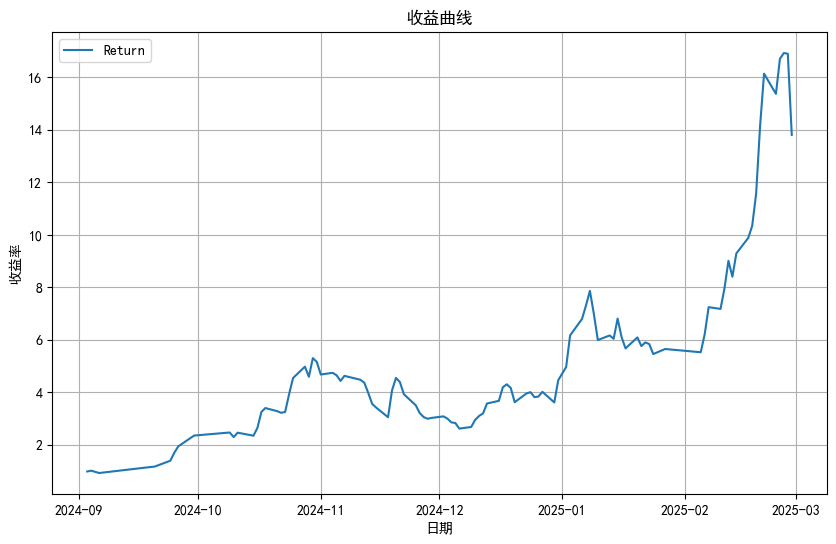

In [15]:
plot(ddwndx, 'cumulative_returns')


In [16]:
ddwndx

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,...,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open,r_return,cumulative_returns
date_key,,,,,,,,,,,,,,,,,,,,,
2024-09-03,936,低吸,中位低吸,002426.XSHE,胜利精密,1,"000038.BKDL,000026.BKDL,000014.BKDL,000035.BKD...","885785.DDBK,885840.DDBK,885467.DDBK,886000.DDB...","980365.ZHBK,980357.ZHBK",4,...,1.76,1.79,1.79,1.80,1.79,1.82,1.81,1.83,-0.017393,0.988889
2024-09-04,963,低吸,中位低吸,001319.XSHE,铭科精技,3,"000026.BKDL,000018.BKDL,000027.BKDL","885467.DDBK,885834.DDBK,885999.DDBK,886000.DDB...",980372.ZHBK,1,...,17.94,17.96,17.96,17.71,17.71,17.89,17.65,17.80,0.021472,1.019359
2024-09-05,1016,低吸,中位低吸,603189.XSHG,网达软件,1,"000012.BKDL,000008.BKDL,000026.BKDL,000015.BKD...","885980.DDBK,885759.DDBK,886062.DDBK,885472.DDB...","980753.ZHBK,980366.ZHBK",1,...,12.96,12.95,12.95,13.00,12.96,12.91,12.91,12.86,0.019218,0.975729
2024-09-06,1057,低吸,中位低吸,603189.XSHG,网达软件,2,"000012.BKDL,000008.BKDL,000026.BKDL,000015.BKD...","885980.DDBK,885759.DDBK,886062.DDBK,885472.DDB...","980753.ZHBK,980366.ZHBK",3,...,12.78,12.78,12.76,12.71,12.71,12.80,12.69,13.13,-0.072592,0.930363
2024-09-19,1364,低吸,中位低吸,002717.XSHE,岭南股份,1,"000012.BKDL,000008.BKDL,000018.BKDL,000023.BKD...","885750.DDBK,885572.DDBK,885694.DDBK,885806.DDB...","980338.ZHBK,980346.ZHBK,980756.ZHBK",2,...,1.39,1.47,1.41,1.46,1.45,1.50,1.46,1.37,0.144985,1.159483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-24,2949,低吸,中位低吸,600678.XSHG,四川金顶,1,"000035.BKDL,000011.BKDL,000027.BKDL,000007.BKD...","885782.DDBK,886021.DDBK,885710.DDBK,885517.DDB...",980368.ZHBK,1,...,9.21,9.61,9.42,9.89,9.63,9.73,9.71,8.78,-0.061364,15.370929
2025-02-25,3006,低吸,中位低吸,001306.XSHE,夏厦精密,2,"000008.BKDL,000038.BKDL,000027.BKDL,000004.BKD...","885930.DDBK,885598.DDBK,885517.DDBK,885929.DDB...",980365.ZHBK,1,...,91.59,90.80,90.09,91.00,90.48,91.38,91.00,87.26,0.014127,16.703977
2025-02-26,3081,低吸,中位低吸,002522.XSHE,浙江众成,1,"000036.BKDL,000006.BKDL,000004.BKDL,000022.BKD...","885924.DDBK,886021.DDBK,885806.DDBK,885929.DDB...","980364.ZHBK,980373.ZHBK",2,...,6.35,6.32,6.32,6.39,6.25,6.27,6.25,6.02,0.050495,16.927068
